#Simple RNN with spectrograms
In this trial we decided to create a simple RNN, calculating the results with and without a dropout layer. The network can take both MFCCs and melspectrogram as input. The results showed are computed with MFCC transormation To get the other results decomment the read_as_melspectrogram function, comment the read_as_mfccs one and choose the right input size.

In [ ]:
import numpy as np 
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook; tqdm.pandas() # Progress bar
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.model_selection import train_test_split
from scipy.io import wavfile
import csv
import random

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import keras
from keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import (Dense, Bidirectional, SimpleRNN, ELU,
                          Dropout, LeakyReLU, Conv1D, BatchNormalization)
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

We define two function to calculate the Melspectrogram and the MFCCs for the further processing.

In [ ]:
def read_as_mfccs(path):
    '''
    Convert audio into a MFCC
    so we can use machine learning
    '''
    y,sr = librosa.load(path, sr=44100)
    
    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    
    return librosa.power_to_db(mfccs)

def read_as_melspectrogram(path):
    '''
    Convert audio into a melspectrogram 
    so we can use machine learning
    '''
    y,sr = librosa.load(path, sr=44100)
    
    melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    
    return librosa.power_to_db(melspectrogram)

def convert_wav_to_image(df): #lo prendi dal csv ogni file
    X = []
    for _,row in tqdm(df.iterrows()):
        x = read_as_mfccs(row.path)
        #x = read_as_melspectrogram(row.path) #decomment and comment the previous row to use melspectrogram 
        X.append(x.transpose())
    return X

Open the csv and create the train, validation and test sets.

In [ ]:
df = pd.read_csv("splitted_total15.csv")
path = df["path"].values
labels = df["label"].values

# Preprocess dataset and create validation sets
X1 = np.array(convert_wav_to_image(df))

train_paths, test_paths, train_labels, test_labels = train_test_split(X1, labels, test_size=0.2, random_state=123)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.15, random_state=123)

1235it [01:41, 12.14it/s]


Here we create the network.

In [ ]:
input_shape=(1034,20)
#input_shape=(1034,128) #decomment and comment the previous row to use melspectrogram
model = keras.Sequential()
model.add(SimpleRNN(256,input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(48, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 256)               70912     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 48)                12336     
                                                                 
 dense_1 (Dense)             (None, 1)                 49        
                                                                 
Total params: 83,297
Trainable params: 83,297
Non-trainable params: 0
_________________________________________________________________


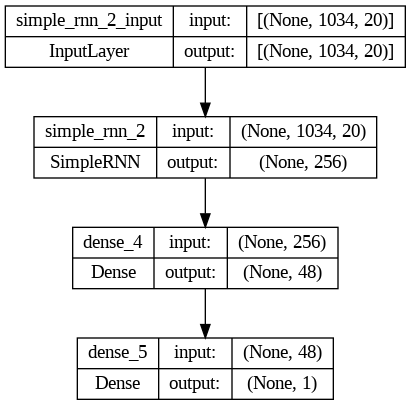

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory, plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

We define the early stopping mechanism, the batch size and the number of epochs. Then, we fit the model.

In [ ]:
learning_rate = 0.00001
optimizer = optimizers.Adam(learning_rate=learning_rate)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
checkpoint_path = 'Notebook'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True)
model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
batch_size=80
epochs = 240
history = model.fit(train_paths, train_labels, epochs=epochs, batch_size = batch_size,
                    validation_data=(val_paths, val_labels), shuffle=False, callbacks=[early_stopping])

Epoch 1/240
11/11 [==============================] - 17s 1s/step - loss: 0.9139 - accuracy: 0.4338 - val_loss: 0.8298 - val_accuracy: 0.4631
Epoch 2/240
11/11 [==============================] - 14s 1s/step - loss: 0.8779 - accuracy: 0.4577 - val_loss: 0.8063 - val_accuracy: 0.4564
Epoch 3/240
11/11 [==============================] - 15s 1s/step - loss: 0.8637 - accuracy: 0.4541 - val_loss: 0.7846 - val_accuracy: 0.4564
Epoch 4/240
11/11 [==============================] - 15s 1s/step - loss: 0.8435 - accuracy: 0.4410 - val_loss: 0.7649 - val_accuracy: 0.4564
Epoch 5/240
11/11 [==============================] - 15s 1s/step - loss: 0.8164 - accuracy: 0.4625 - val_loss: 0.7465 - val_accuracy: 0.4631
Epoch 6/240
11/11 [==============================] - 14s 1s/step - loss: 0.8136 - accuracy: 0.4768 - val_loss: 0.7296 - val_accuracy: 0.4765
Epoch 7/240
11/11 [==============================] - 14s 1s/step - loss: 0.8060 - accuracy: 0.4827 - val_loss: 0.7141 - val_accuracy: 0.5168
Epoch 8/240
1

Plotting the loss function and the accuracy for both train and validation set.

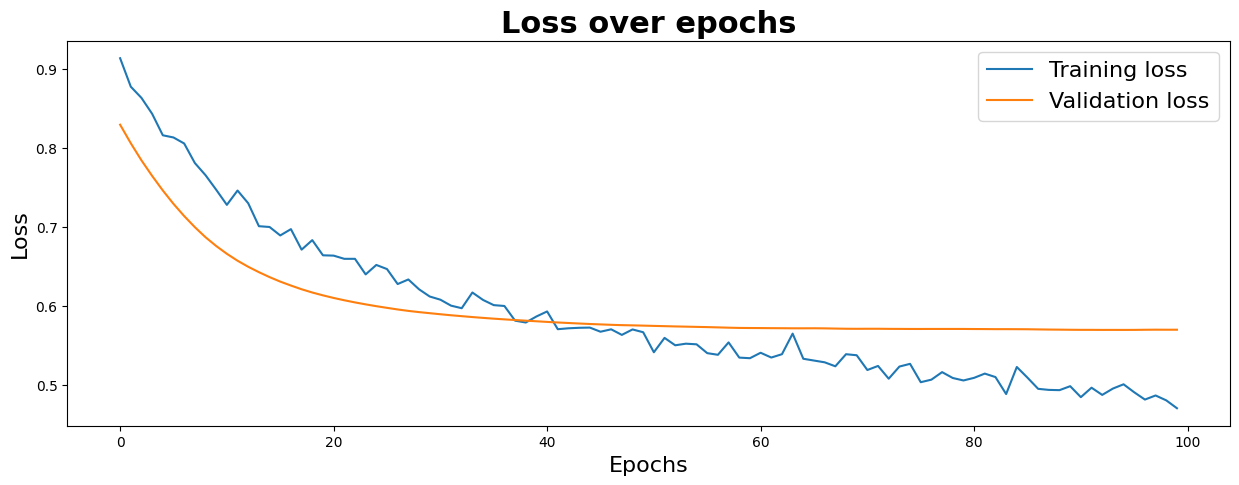

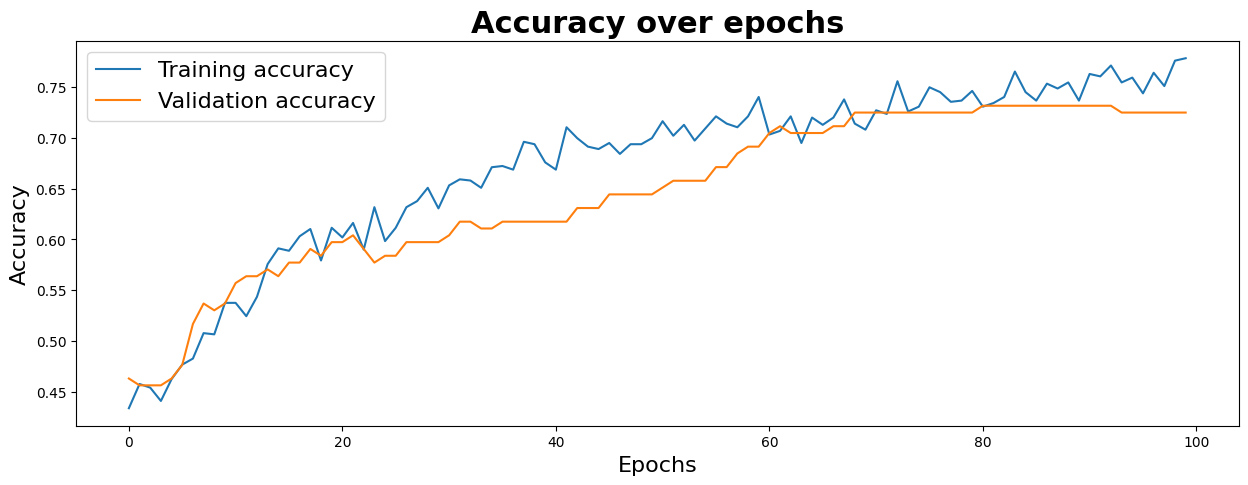

In [ ]:
# Visualize loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_executed = early_stopping.stopped_epoch + 1
if epochs_executed != 1:
    rg = epochs_executed
else:
    rg = epochs    
plt.figure(figsize=(15,5))
plt.plot(range(rg), loss)
plt.plot(range(rg), val_loss)
plt.title('Loss over epochs', weight='bold', fontsize=22)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(['Training loss', 'Validation loss'], fontsize=16)
plt.show()

# Visualize Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(15,5))
plt.plot(range(rg), acc)
plt.plot(range(rg), val_acc)
plt.title('Accuracy over epochs', weight='bold', fontsize=22)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(['Training accuracy', 'Validation accuracy'], fontsize=16)
plt.show()

Evaluating the model on the test set, calculating the confusion matrix, the f1-score, the recall and the accuracy

8/8 [==============================] - 2s 231ms/step


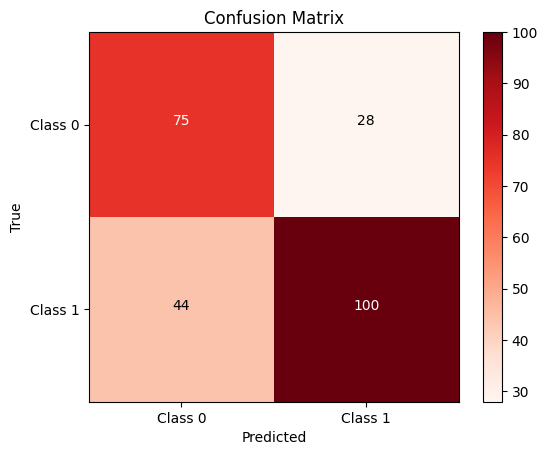

              precision    recall  f1-score   support

           0       0.63      0.73      0.68       103
           1       0.78      0.69      0.74       144

    accuracy                           0.71       247
   macro avg       0.71      0.71      0.71       247
weighted avg       0.72      0.71      0.71       247



In [ ]:
test_loss, test_accuracy = model.evaluate(test_paths, test_labels)


# Make predictions using your model
prediction = model.predict(test_paths)
# Convert the predicted probabilities to class labels (0 or 1 in this case)
y_pred = (prediction > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, y_pred)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Class 0', 'Class 1'])
plt.yticks(tick_marks, ['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
# Add text annotations within each cell
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

from sklearn.metrics import classification_report


# Ottieni le predizioni del modello sul test set
predicted_probabilities = prediction.flatten()  # Appiattisci le probabilità
predicted_labels = (predicted_probabilities >= 0.5).astype(int)

# Calcola l'F1-score, il recall e l'accuratezza
report = classification_report(test_labels, predicted_labels)
print(report)

Saving the checkpoint of the network

In [ ]:
model.save("Notebook")

INFO:tensorflow:Assets written to: Notebook\assets
